# HW3: Quantum Annealers

### Part 1: Largest Embeddable Graphs per QA and Graph Type

- Enumerate available D-Wave **physical QPU** solvers.
- For each QPU and each specified **graph family** (SK, 3-regular, ER, BA-1, BA-2), search for the largest logical problem size \(N\) that can be embedded on the QPU hardware graph using a heuristic embedding tool.
- Record the largest embeddable size and keep one successful embedding per (solver, graph type) as a template for later parts.


In [51]:
# Imports for Part 1

import numpy as np
import networkx as nx
import pandas as pd

from dwave.cloud import Client
from minorminer import find_embedding

# Create a D-Wave client instance (reads config from dwave.conf or environment)
client = Client.from_config()

print("Connected to D-Wave cloud.")


Connected to D-Wave cloud.


In [52]:
# Enumerate available physical QPU solvers and inspect their hardware graphs


def get_qpu_solvers(dwave_client: Client):
    """Return a list of *physical QPU* solvers available to the user.

    Hybrid solvers are excluded; we only keep solvers with solver.qpu == True.
    """
    solvers = [s for s in dwave_client.get_solvers() if getattr(s, "qpu", False)]

    print("Available physical QPU solvers")
    print("==============================")
    for s in solvers:
        print(f"{s.name}")
        print("  num_qubits        ", s.num_qubits)
        print("  num_active_qubits", s.num_active_qubits)
        print("  #undirected_edges ", len(s.undirected_edges))
        print()

    return solvers


qpu_solvers = get_qpu_solvers(client)


Available physical QPU solvers
Advantage_system6.4
  num_qubits         5760
  num_active_qubits 5612
  #undirected_edges  40088

Advantage_system4.1
  num_qubits         5760
  num_active_qubits 5627
  #undirected_edges  40279

Advantage2_system1.8
  num_qubits         4800
  num_active_qubits 4591
  #undirected_edges  41766



### Graph family generators

- **SK**: Sherrington–Kirkpatrick (complete graph)
- **3-reg**: 3-regular graphs
- **ER**: Erdős–Rényi graphs
- **BA-1**: Barabási–Albert with attachment parameter \(m = 1\)
- **BA-2**: Barabási–Albert with attachment parameter \(m = 2\)

Each function call generates a *logical* problem graph on \(N\) nodes that we will try to embed into a given QPU hardware graph.


In [53]:
# Graph family generation utilities

RANDOM_SEED_BASE = 1234


def generate_problem_graph(graph_type: str, n: int, seed: int | None = None) -> nx.Graph:
    """Generate a logical problem graph of size n for the given graph family.

    Parameters
    ----------
    graph_type : {"SK", "3-reg", "ER", "BA-1", "BA-2"}
        Name of the graph family.
    n : int
        Number of logical nodes.
    seed : int | None
        Random seed for reproducibility.
    """
    if n <= 0:
        raise ValueError("n must be positive")

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    if graph_type == "SK":
        # Complete graph on n nodes
        G = nx.complete_graph(n)

    elif graph_type == "3-reg":
        # 3-regular graphs require 3*n to be even; if not, bump n by 1 internally.
        if (3 * n) % 2 == 1:
            n = n + 1
        G = nx.random_regular_graph(3, n, seed=int(rng.integers(0, 2**31 - 1)))

    elif graph_type == "ER":
        # Use a reasonably dense Erdős–Rényi graph; p can be tuned if desired.
        p = 0.5
        G = nx.gnp_random_graph(n, p, seed=int(rng.integers(0, 2**31 - 1)))

    elif graph_type == "BA-1":
        # Barabási–Albert with m = 1 (tree-like)
        m = 1
        if n <= m:
            raise ValueError("BA-1 requires n > 1")
        G = nx.barabasi_albert_graph(n, m, seed=int(rng.integers(0, 2**31 - 1)))

    elif graph_type == "BA-2":
        # Barabási–Albert with m = 2 (denser scale-free)
        m = 2
        if n <= m:
            raise ValueError("BA-2 requires n > 2")
        G = nx.barabasi_albert_graph(n, m, seed=int(rng.integers(0, 2**31 - 1)))

    else:
        raise ValueError(f"Unknown graph_type: {graph_type}")

    # Relabel nodes to 0..n-1 just to be safe
    return nx.convert_node_labels_to_integers(G)


### Embedding search strategy

For each pair **(QA solver, graph type)** we:
- Incrementally increase the number of logical nodes \(N\) in steps.
- For each \(N\), generate several random instances of the chosen graph family.
- For each instance, attempt to find an embedding into the QPU hardware graph using `minorminer.find_embedding` with a few random seeds.
- The **largest embeddable size** for that (solver, graph type) is the maximum \(N\) for which we successfully found at least one embedding.

We also store one successful embedding as a *template* for later parts of the homework.


In [54]:
# Embedding search helper


def find_largest_embeddable_size(
    solver,
    graph_type: str,
    N_start: int = 8,
    N_step: int = 16,
    N_max: int = 128,
    num_instances_per_N: int = 3,
    embedding_attempts_per_instance: int = 3,
    embedding_timeout_ms: int = 5_000,
):
    """Search for the largest logical size N embeddable on the given solver.

    We increase N linearly (with `N_step`) until we fail to find an embedding.
    Each embedding attempt is time-bounded via `embedding_timeout_ms` so the
    overall runtime stays manageable (~30 minutes target for all pairs).

    Returns
    -------
    best_N : int
        Largest N with at least one successful embedding (0 if none).
    best_embedding_info : dict | None
        Dictionary containing a representative embedding and metadata that we
        will reuse later, or None if no embedding was found.
    """
    hardware_edges = list(solver.undirected_edges)

    best_N: int = 0
    best_embedding_info: dict | None = None

    for N in range(N_start, N_max + 1, N_step):
        print(f"[{solver.name} | {graph_type}] Trying N = {N} ...")
        embeddable_for_N = False

        for instance_id in range(num_instances_per_N):
            try:
                G = generate_problem_graph(graph_type, N, seed=RANDOM_SEED_BASE + instance_id)
            except ValueError as exc:
                # Some families (e.g., BA) require N > m; just skip infeasible N.
                print(f"  Skipping N={N} for instance {instance_id}: {exc}")
                continue

            problem_edges = list(G.edges())
            if not problem_edges:
                # An edgeless graph is trivially embeddable, but not interesting.
                print(f"  Graph for N={N}, instance {instance_id} has no edges; skipping.")
                continue

            for attempt in range(embedding_attempts_per_instance):
                seed = RANDOM_SEED_BASE + 1000 * instance_id + attempt
                embedding = find_embedding(
                    problem_edges,
                    hardware_edges,
                    random_seed=seed,
                    timeout=embedding_timeout_ms,
                )

                if embedding:  # Non-empty dict = success
                    print(f"  Success for N={N}, instance {instance_id}, attempt {attempt}.")
                    embeddable_for_N = True
                    best_N = N
                    best_embedding_info = {
                        "solver_name": solver.name,
                        "graph_type": graph_type,
                        "N": N,
                        "graph": G,
                        "embedding": embedding,
                    }
                    break

            if embeddable_for_N:
                break

        if not embeddable_for_N:
            print(f"  No embedding found for N={N}; stopping search for this pair.")
            break

    return best_N, best_embedding_info


In [55]:
# Run the embedding search for all (QA solver, graph type) pairs

GRAPH_TYPES = ["SK", "3-reg", "ER", "BA-1", "BA-2"]

# Table of largest embeddable sizes
results_rows: list[dict] = []

# Dictionary to store one successful embedding template per (solver_name, graph_type)
embedding_templates: dict[tuple[str, str], dict] = {}

for solver in qpu_solvers:
    row = {"QA solver": solver.name}

    for graph_type in GRAPH_TYPES:
        best_N, best_embedding_info = find_largest_embeddable_size(
            solver,
            graph_type,
            N_start=8,
            N_step=16,
            N_max=128,
            num_instances_per_N=3,
            embedding_attempts_per_instance=3,
            embedding_timeout_ms=5_000,
        )

        row[graph_type] = best_N

        if best_embedding_info is not None:
            embedding_templates[(solver.name, graph_type)] = best_embedding_info

    results_rows.append(row)

# Convert to a DataFrame for a clean table view
results_df = pd.DataFrame(results_rows)
results_df


[Advantage_system6.4 | SK] Trying N = 8 ...
  Success for N=8, instance 0, attempt 0.
[Advantage_system6.4 | SK] Trying N = 24 ...
  Success for N=24, instance 0, attempt 0.
[Advantage_system6.4 | SK] Trying N = 40 ...
  Success for N=40, instance 0, attempt 0.
[Advantage_system6.4 | SK] Trying N = 56 ...
  Success for N=56, instance 0, attempt 0.
[Advantage_system6.4 | SK] Trying N = 72 ...
  Success for N=72, instance 0, attempt 0.
[Advantage_system6.4 | SK] Trying N = 88 ...
  Success for N=88, instance 0, attempt 0.
[Advantage_system6.4 | SK] Trying N = 104 ...
  Success for N=104, instance 0, attempt 0.
[Advantage_system6.4 | SK] Trying N = 120 ...
  Success for N=120, instance 0, attempt 0.
[Advantage_system6.4 | 3-reg] Trying N = 8 ...
  Success for N=8, instance 0, attempt 0.
[Advantage_system6.4 | 3-reg] Trying N = 24 ...
  Success for N=24, instance 0, attempt 0.
[Advantage_system6.4 | 3-reg] Trying N = 40 ...
  Success for N=40, instance 0, attempt 0.
[Advantage_system6.4 | 

,QA solver,SK,3-reg,ER,BA-1,BA-2
0,Advantage_system6.4,120,120,120,120,120
1,Advantage_system4.1,120,120,120,120,120
2,Advantage2_system1.8,120,120,120,120,120


### Part 2: Simulated Annealing (SA) Baseline

In this part, we solve **75 problem instances** using classical simulated annealing:

- **5 graph types**: SK, 3-reg, ER, BA-1, BA-2
- **3 coefficient distributions**: Random Choice (±1), Uniform [-1,1], Gaussian N(0,1)
- **5 instances** per (graph type, coefficient distribution) pair
- **Total**: 5 × 3 × 5 = 75 problems

For each instance, we use 1000 reads and compute the **Best-Sample Score (BSS)**:

$$\text{BSS} = E_{\text{min}} \times f_{\text{min}}$$

where:
- $E_{\text{min}}$ = lowest energy among all samples
- $f_{\text{min}}$ = number of samples achieving that energy

More negative BSS indicates better performance.


In [57]:
# Imports for Part 2

import dimod
from dwave.samplers import SimulatedAnnealingSampler


In [59]:
# Coefficient distribution generators


def generate_ising_coefficients(
    graph: nx.Graph,
    coeff_distribution: str,
    seed: int | None = None,
):
    """Generate h and J coefficients for an Ising problem on the given graph.

    Parameters
    ----------
    graph : nx.Graph
        The problem graph structure.
    coeff_distribution : {"random_choice", "uniform", "gaussian"}
        Distribution for generating coefficients.
    seed : int | None
        Random seed for reproducibility.

    Returns
    -------
    h : dict
        Linear coefficients {node: value}.
    J : dict
        Quadratic coefficients {(node_i, node_j): value}.
    """
    rng = np.random.default_rng(seed)
    n = graph.number_of_nodes()

    # Generate linear coefficients (h)
    # For SK model, typically h=0, but we'll generate for all graph types
    h = {}
    for node in graph.nodes():
        if coeff_distribution == "random_choice":
            h[node] = rng.choice([-1, 1])
        elif coeff_distribution == "uniform":
            h[node] = rng.uniform(-1, 1)
        elif coeff_distribution == "gaussian":
            h[node] = rng.normal(0, 1)
        else:
            raise ValueError(f"Unknown coeff_distribution: {coeff_distribution}")

    # Generate quadratic coefficients (J)
    J = {}
    for edge in graph.edges():
        if coeff_distribution == "random_choice":
            J[edge] = rng.choice([-1, 1])
        elif coeff_distribution == "uniform":
            J[edge] = rng.uniform(-1, 1)
        elif coeff_distribution == "gaussian":
            J[edge] = rng.normal(0, 1)
        else:
            raise ValueError(f"Unknown coeff_distribution: {coeff_distribution}")

    return h, J


print("Coefficient generation functions ready.")


Coefficient generation functions ready.


In [60]:
# Best-Sample Score (BSS) calculation


def calculate_bss(sampleset):
    """Calculate the Best-Sample Score (BSS) for a sampleset.

    BSS = E_min × f_min

    where:
    - E_min = lowest energy among all samples
    - f_min = number of samples achieving that energy

    Parameters
    ----------
    sampleset : dimod.SampleSet
        The sampleset from a sampler.

    Returns
    -------
    bss : float
        The Best-Sample Score.
    e_min : float
        The minimum energy.
    f_min : int
        The frequency of the minimum energy.
    """
    # Aggregate to count unique samples
    agg_sampleset = sampleset.aggregate()

    # Get the best (lowest energy) sample
    e_min = agg_sampleset.first.energy
    f_min = agg_sampleset.first.num_occurrences

    bss = e_min * f_min

    return bss, e_min, f_min


print("BSS calculation function ready.")


BSS calculation function ready.


In [61]:
# Generate all 75 problem instances and solve with SA

COEFF_DISTRIBUTIONS = ["random_choice", "uniform", "gaussian"]
NUM_INSTANCES = 5
PROBLEM_SIZE_N = 120  # Use the largest embeddable size from Part 1
NUM_READS_SA = 1000

# Initialize SA sampler
sa_sampler = SimulatedAnnealingSampler()

# Storage for all results
sa_results = []

# Storage for problem instances
problem_instances = []

print(f"Generating and solving {len(GRAPH_TYPES) * len(COEFF_DISTRIBUTIONS) * NUM_INSTANCES} problem instances...")
print(f"Problem size: N = {PROBLEM_SIZE_N}")
print(f"Number of SA reads per instance: {NUM_READS_SA}")
print("=" * 80)

instance_counter = 0

for graph_type in GRAPH_TYPES:
    # Get the embedded graph from Part 1 for this graph type
    # Use the first available solver's embedding
    emb_key = (qpu_solvers[0].name, graph_type)
    
    if emb_key in embedding_templates:
        # Use the graph that was successfully embedded in Part 1
        G_template = embedding_templates[emb_key]["graph"]
        print(f"\nUsing embedded graph from Part 1 for {graph_type} (N={G_template.number_of_nodes()})")
    else:
        print(f"\nWARNING: No embedding template found for {graph_type}. Generating new graph.")
        G_template = generate_problem_graph(graph_type, PROBLEM_SIZE_N, seed=RANDOM_SEED_BASE)
    
    for coeff_dist in COEFF_DISTRIBUTIONS:
        print(f"\nProcessing: {graph_type} | {coeff_dist}")

        for instance_id in range(NUM_INSTANCES):
            instance_counter += 1

            # Use the embedded graph structure from Part 1
            G = G_template.copy()  # Use the same graph structure

            # Generate NEW coefficients
            coeff_seed = RANDOM_SEED_BASE + 10000 + instance_counter
            h, J = generate_ising_coefficients(G, coeff_dist, seed=coeff_seed)

            # Store problem instance for reuse in Part 3
            problem_instances.append({
                "instance_counter": instance_counter,
                "graph_type": graph_type,
                "coeff_dist": coeff_dist,
                "instance_id": instance_id,
                "graph": G,
                "h": h,
                "J": J,
            })

            # Solve with SA
            sampleset = sa_sampler.sample_ising(h, J, num_reads=NUM_READS_SA)

            # Calculate BSS
            bss, e_min, f_min = calculate_bss(sampleset)

            # Store sampleset for Part 5 postprocessing
            problem_instances[-1]["sa_sampleset"] = sampleset

            # Store results
            sa_results.append({
                "instance_counter": instance_counter,
                "graph_type": graph_type,
                "coeff_dist": coeff_dist,
                "instance_id": instance_id,
                "N": G.number_of_nodes(),
                "num_edges": G.number_of_edges(),
                "e_min": e_min,
                "f_min": f_min,
                "bss": bss,
            })

            print(f"  Instance {instance_id}: BSS = {bss:.2f} (E_min = {e_min:.2f}, f_min = {f_min})")

print("\n" + "=" * 80)
print(f"Completed solving all {instance_counter} instances with SA.")

# Convert to DataFrame
sa_results_df = pd.DataFrame(sa_results)
sa_results_df.head(10)


Generating and solving 75 problem instances...
Problem size: N = 120
Number of SA reads per instance: 1000

Using embedded graph from Part 1 for SK (N=120)

Processing: SK | random_choice
  Instance 0: BSS = -26656.00 (E_min = -952.00, f_min = 28)
  Instance 1: BSS = -307092.00 (E_min = -978.00, f_min = 314)
  Instance 2: BSS = -53648.00 (E_min = -958.00, f_min = 56)
  Instance 3: BSS = -128372.00 (E_min = -958.00, f_min = 134)
  Instance 4: BSS = -70148.00 (E_min = -988.00, f_min = 71)

Processing: SK | uniform
  Instance 0: BSS = -77034.18 (E_min = -554.20, f_min = 139)
  Instance 1: BSS = -64640.30 (E_min = -567.02, f_min = 114)
  Instance 2: BSS = -144214.91 (E_min = -561.15, f_min = 257)
  Instance 3: BSS = -161872.96 (E_min = -576.06, f_min = 281)
  Instance 4: BSS = -76504.61 (E_min = -558.43, f_min = 137)

Processing: SK | gaussian
  Instance 0: BSS = -461280.60 (E_min = -996.29, f_min = 463)
  Instance 1: BSS = -115299.95 (E_min = -960.83, f_min = 120)
  Instance 2: BSS = -541

,instance_counter,graph_type,coeff_dist,instance_id,N,num_edges,e_min,f_min,bss
0,1,SK,random_choice,0,120,7140,-952.000000,28,-26656.000000
1,2,SK,random_choice,1,120,7140,-978.000000,314,-307092.000000
2,3,SK,random_choice,2,120,7140,-958.000000,56,-53648.000000
3,4,SK,random_choice,3,120,7140,-958.000000,134,-128372.000000
4,5,SK,random_choice,4,120,7140,-988.000000,71,-70148.000000
5,6,SK,uniform,0,120,7140,-554.202767,139,-77034.184654
6,7,SK,uniform,1,120,7140,-567.020217,114,-64640.304770
7,8,SK,uniform,2,120,7140,-561.147516,257,-144214.911593
8,9,SK,uniform,3,120,7140,-576.060366,281,-161872.962923
9,10,SK,uniform,4,120,7140,-558.427778,137,-76504.605568


In [62]:
# Compute mean BSS for each (graph_type, coeff_dist) pair

sa_summary = sa_results_df.groupby(["graph_type", "coeff_dist"]).agg({
    "bss": ["mean", "std"],
    "e_min": ["mean", "std"],
    "f_min": ["mean", "std"],
}).round(2)

print("SA Baseline Results: Mean BSS over 5 instances per (graph type, coefficient distribution) pair")
print("=" * 80)
print(sa_summary)

# Pivot table for cleaner visualization
sa_mean_bss_pivot = sa_results_df.pivot_table(
    values="bss",
    index="graph_type",
    columns="coeff_dist",
    aggfunc="mean"
).round(2)

print("\n" + "=" * 80)
print("Mean BSS Table (rows = graph types, columns = coefficient distributions)")
print("=" * 80)
print(sa_mean_bss_pivot)


SA Baseline Results: Mean BSS over 5 instances per (graph type, coefficient distribution) pair
                                bss              e_min         f_min        
                               mean        std    mean    std   mean     std
graph_type coeff_dist                                                       
3-reg      gaussian        -4843.68    3791.05 -171.07   4.44   28.2   21.97
           random_choice    -179.20       7.29 -179.20   7.29    1.0    0.00
           uniform        -10467.00    6608.23 -101.79   5.12  102.8   65.78
BA-1       gaussian       -36367.73   27284.91 -141.08   8.10  253.0  182.16
           random_choice    -151.80       7.01 -151.80   7.01    1.0    0.00
           uniform        -11174.19    5833.58  -87.08   3.13  126.8   62.58
BA-2       gaussian       -17516.37    9880.45 -189.84   3.49   92.2   51.93
           random_choice  -19175.20   24665.38 -200.80   3.03   95.2  121.99
           uniform        -26129.33   27614.85 -110.83   4

### Part 2 Results Summary

The SA baseline results are stored in:
- **`sa_results_df`**: Full results for all 75 instances
- **`sa_mean_bss_pivot`**: Mean BSS values organized as a table (graph types × coefficient distributions)

**Key observations to note:**
- BSS = $E_{\text{min}} \times f_{\text{min}}$ is typically negative
- More negative BSS indicates better performance (lower energy, higher frequency)
- Different graph types may have different characteristic energies
- Coefficient distributions affect the energy landscape and solution quality

These results will serve as a **classical baseline** for comparison with quantum annealing in later parts.


In [64]:
# Save SA results to CSV for future reference

sa_results_df.to_csv("sa_results.csv", index=False)
sa_mean_bss_pivot.to_csv("sa_mean_bss_summary.csv")

print("SA results saved to:")
print("  - sa_results.csv (all 75 instances)")
print("  - sa_mean_bss_summary.csv (mean BSS per graph type and coeff distribution)")


SA results saved to:
  - sa_results.csv (all 75 instances)
  - sa_mean_bss_summary.csv (mean BSS per graph type and coeff distribution)


### Part 3: Quantum Annealing (QA) on Selected Solver

In this part, we solve the **same 75 problem instances** using a physical D-Wave quantum annealer.

**Setup:**
- Use the same problem instances generated in Part 2
- Use embeddings from Part 1 for each graph type
- Use 1000 reads per instance
- Compute BSS using the same definition as Part 2
- Report mean BSS for each (graph type, coefficient distribution) pair

**Key steps:**
1. Select one QA solver (we'll use the first available)
2. For each instance, use the embedding template for that graph type
3. Embed the Ising problem (h, J) onto the hardware graph
4. Sample from the QA with 1000 reads
5. Unembed the results back to the logical problem space
6. Calculate BSS


In [65]:
# Imports for Part 3

from dwave.embedding import embed_ising, unembed_sampleset

print("Imports ready for Part 3.")


Imports ready for Part 3.


In [67]:
# Solve all 75 problem instances on the QA

NUM_READS_QA = 1000

# Storage for QA results
qa_results = []

# Create hardware graph for embedding
G_hardware = nx.Graph(selected_solver.undirected_edges)

print(f"Solving {len(problem_instances)} problem instances on {selected_solver.name}")
print(f"Number of QA reads per instance: {NUM_READS_QA}")
print("=" * 80)

for idx, problem in enumerate(problem_instances):
    instance_counter = problem["instance_counter"]
    graph_type = problem["graph_type"]
    coeff_dist = problem["coeff_dist"]
    instance_id = problem["instance_id"]
    G = problem["graph"]
    h = problem["h"]
    J = problem["J"]

    print(f"\n[{idx+1}/{len(problem_instances)}] Processing: {graph_type} | {coeff_dist} | instance {instance_id}")

    # Get the embedding for this graph type
    emb_key = (selected_solver.name, graph_type)
    if emb_key not in embedding_templates:
        print(f"  ERROR: No embedding template found for {graph_type}. Skipping.")
        continue

    embedding = embedding_templates[emb_key]["embedding"]

    # Check if embedding size matches problem size
    if len(embedding) != G.number_of_nodes():
        print(f"  WARNING: Embedding size ({len(embedding)}) != problem size ({G.number_of_nodes()})")
        print(f"  Skipping this instance.")
        continue

    try:
        # Embed the Ising problem
        h_embedded, J_embedded = embed_ising(h, J, embedding, G_hardware.adj)

        # Solve on QA
        qa_job = selected_solver.sample_ising(h_embedded, J_embedded, num_reads=NUM_READS_QA)
        qa_sampleset = qa_job.sampleset

        # Create BQM for unembedding
        bqm = dimod.BinaryQuadraticModel(h, J, offset=0.0, vartype=dimod.SPIN)

        # Unembed the results
        unembedded_sampleset = unembed_sampleset(qa_sampleset, embedding, bqm)

        # Calculate BSS
        bss, e_min, f_min = calculate_bss(unembedded_sampleset)

        # Store sampleset for Part 5 postprocessing
        problem["qa_sampleset"] = unembedded_sampleset
        problem["bqm"] = bqm

        # Store results
        qa_results.append({
            "instance_counter": instance_counter,
            "graph_type": graph_type,
            "coeff_dist": coeff_dist,
            "instance_id": instance_id,
            "N": G.number_of_nodes(),
            "num_edges": G.number_of_edges(),
            "e_min": e_min,
            "f_min": f_min,
            "bss": bss,
        })

        print(f"  ✓ BSS = {bss:.2f} (E_min = {e_min:.2f}, f_min = {f_min})")

    except Exception as e:
        print(f"  ERROR: {e}")
        continue

print("\n" + "=" * 80)
print(f"Completed solving {len(qa_results)} instances on QA.")

# Convert to DataFrame
qa_results_df = pd.DataFrame(qa_results)
qa_results_df.head(10)


Solving 75 problem instances on Advantage_system6.4
Number of QA reads per instance: 1000

[1/75] Processing: SK | random_choice | instance 0
  ✓ BSS = -928.00 (E_min = -928.00, f_min = 1)

[2/75] Processing: SK | random_choice | instance 1
  ✓ BSS = -962.00 (E_min = -962.00, f_min = 1)

[3/75] Processing: SK | random_choice | instance 2
  ✓ BSS = -906.00 (E_min = -906.00, f_min = 1)

[4/75] Processing: SK | random_choice | instance 3
  ✓ BSS = -922.00 (E_min = -922.00, f_min = 1)

[5/75] Processing: SK | random_choice | instance 4
  ✓ BSS = -936.00 (E_min = -936.00, f_min = 1)

[6/75] Processing: SK | uniform | instance 0
  ✓ BSS = -530.89 (E_min = -530.89, f_min = 1)

[7/75] Processing: SK | uniform | instance 1
  ✓ BSS = -545.55 (E_min = -545.55, f_min = 1)

[8/75] Processing: SK | uniform | instance 2
  ✓ BSS = -547.22 (E_min = -547.22, f_min = 1)

[9/75] Processing: SK | uniform | instance 3
  ✓ BSS = -554.43 (E_min = -554.43, f_min = 1)

[10/75] Processing: SK | uniform | instanc

,instance_counter,graph_type,coeff_dist,instance_id,N,num_edges,e_min,f_min,bss
0,1,SK,random_choice,0,120,7140,-928.000000,1,-928.000000
1,2,SK,random_choice,1,120,7140,-962.000000,1,-962.000000
2,3,SK,random_choice,2,120,7140,-906.000000,1,-906.000000
3,4,SK,random_choice,3,120,7140,-922.000000,1,-922.000000
4,5,SK,random_choice,4,120,7140,-936.000000,1,-936.000000
5,6,SK,uniform,0,120,7140,-530.886412,1,-530.886412
6,7,SK,uniform,1,120,7140,-545.548932,1,-545.548932
7,8,SK,uniform,2,120,7140,-547.216952,1,-547.216952
8,9,SK,uniform,3,120,7140,-554.429487,1,-554.429487
9,10,SK,uniform,4,120,7140,-543.097055,1,-543.097055


In [68]:
# Compute mean BSS for each (graph_type, coeff_dist) pair for QA

qa_summary = qa_results_df.groupby(["graph_type", "coeff_dist"]).agg({
    "bss": ["mean", "std"],
    "e_min": ["mean", "std"],
    "f_min": ["mean", "std"],
}).round(2)

print("QA Results: Mean BSS over 5 instances per (graph type, coefficient distribution) pair")
print("=" * 80)
print(qa_summary)

# Pivot table for cleaner visualization
qa_mean_bss_pivot = qa_results_df.pivot_table(
    values="bss",
    index="graph_type",
    columns="coeff_dist",
    aggfunc="mean"
).round(2)

print("\n" + "=" * 80)
print("QA Mean BSS Table (rows = graph types, columns = coefficient distributions)")
print("=" * 80)
print(qa_mean_bss_pivot)


QA Results: Mean BSS over 5 instances per (graph type, coefficient distribution) pair
                              bss             e_min        f_min       
                             mean       std    mean    std  mean    std
graph_type coeff_dist                                                  
3-reg      gaussian       -169.70      4.49 -169.70   4.49   1.0   0.00
           random_choice  -179.20      7.29 -179.20   7.29   1.0   0.00
           uniform        -460.80    556.04 -101.74   5.11   4.4   5.27
BA-1       gaussian       -140.41      8.09 -140.41   8.09   1.0   0.00
           random_choice  -151.80      7.01 -151.80   7.01   1.0   0.00
           uniform         -87.01      3.19  -87.01   3.19   1.0   0.00
BA-2       gaussian       -187.90      4.22 -187.90   4.22   1.0   0.00
           random_choice -8647.20  13920.07 -200.80   3.03  42.8  68.88
           uniform        -477.71    538.45 -110.79   4.40   4.2   4.66
ER         gaussian       -641.11     13.66 -641.1

In [69]:
# Save QA results to CSV

qa_results_df.to_csv("qa_results.csv", index=False)
qa_mean_bss_pivot.to_csv("qa_mean_bss_summary.csv")

print("QA results saved to:")
print("  - qa_results.csv (all instances)")
print("  - qa_mean_bss_summary.csv (mean BSS per graph type and coeff distribution)")


QA results saved to:
  - qa_results.csv (all instances)
  - qa_mean_bss_summary.csv (mean BSS per graph type and coeff distribution)


### Part 4: Comparing SA and QA Using Relative Performance

For each instance, we now have results from both SA and QA. We define the **relative performance metric**:

$$R = \frac{S_{\text{QA}}}{S_{\text{SA}}} = \frac{\text{BSS}_{\text{QA}}}{\text{BSS}_{\text{SA}}}$$

**Interpretation** (since BSS is negative):
- **R > 1**: QA has a more negative (better) BSS than SA → **QA outperforms SA**
- **R < 1**: SA has a more negative (better) BSS → **SA outperforms QA**
- **R ≈ 1**: Similar performance

**Analysis goals:**
- Compute R for all 75 instances
- Identify graph families where QA consistently outperforms SA or vice versa
- Analyze trends across different coefficient distributions (Random Choice, Uniform, Gaussian)


In [70]:
# Merge SA and QA results and compute relative performance metric R

# Merge on instance_counter to ensure we're comparing the same instances
comparison_df = pd.merge(
    sa_results_df,
    qa_results_df,
    on=["instance_counter", "graph_type", "coeff_dist", "instance_id"],
    suffixes=("_sa", "_qa")
)

# Compute relative performance metric R = BSS_QA / BSS_SA
comparison_df["R"] = comparison_df["bss_qa"] / comparison_df["bss_sa"]

# Add interpretation column
def interpret_r(r):
    if r > 1.05:  # QA significantly better
        return "QA better"
    elif r < 0.95:  # SA significantly better
        return "SA better"
    else:
        return "Similar"

comparison_df["performance"] = comparison_df["R"].apply(interpret_r)

print(f"Comparison dataset created with {len(comparison_df)} instances")
print("\nFirst 10 comparisons:")
print(comparison_df[["graph_type", "coeff_dist", "instance_id", "bss_sa", "bss_qa", "R", "performance"]].head(10))

# Summary statistics
print("\n" + "=" * 80)
print("Overall Performance Summary:")
print(f"  QA better: {(comparison_df['performance'] == 'QA better').sum()} instances")
print(f"  SA better: {(comparison_df['performance'] == 'SA better').sum()} instances")
print(f"  Similar:   {(comparison_df['performance'] == 'Similar').sum()} instances")


Comparison dataset created with 75 instances

First 10 comparisons:
  graph_type     coeff_dist  instance_id         bss_sa      bss_qa         R  \
0         SK  random_choice            0  -26656.000000 -928.000000  0.034814   
1         SK  random_choice            1 -307092.000000 -962.000000  0.003133   
2         SK  random_choice            2  -53648.000000 -906.000000  0.016888   
3         SK  random_choice            3 -128372.000000 -922.000000  0.007182   
4         SK  random_choice            4  -70148.000000 -936.000000  0.013343   
5         SK        uniform            0  -77034.184654 -530.886412  0.006892   
6         SK        uniform            1  -64640.304770 -545.548932  0.008440   
7         SK        uniform            2 -144214.911593 -547.216952  0.003794   
8         SK        uniform            3 -161872.962923 -554.429487  0.003425   
9         SK        uniform            4  -76504.605568 -543.097055  0.007099   

  performance  
0   SA better  
1   SA b

In [71]:
# Analyze mean R by graph type and coefficient distribution

# Group by (graph_type, coeff_dist)
r_summary = comparison_df.groupby(["graph_type", "coeff_dist"]).agg({
    "R": ["mean", "std", "min", "max"],
    "bss_sa": "mean",
    "bss_qa": "mean",
}).round(3)

print("Mean Relative Performance (R) by Graph Type and Coefficient Distribution")
print("=" * 80)
print(r_summary)

# Pivot table for R values
r_pivot = comparison_df.pivot_table(
    values="R",
    index="graph_type",
    columns="coeff_dist",
    aggfunc="mean"
).round(3)

print("\n" + "=" * 80)
print("Mean R Table (rows = graph types, columns = coefficient distributions)")
print("=" * 80)
print(r_pivot)
print("\nInterpretation: R > 1 means QA is better, R < 1 means SA is better")


Mean Relative Performance (R) by Graph Type and Coefficient Distribution
                              R                           bss_sa    bss_qa
                           mean    std    min    max        mean      mean
graph_type coeff_dist                                                     
3-reg      gaussian       0.049  0.024  0.015  0.071   -4843.683  -169.700
           random_choice  1.000  0.000  1.000  1.000    -179.200  -179.200
           uniform        0.040  0.028  0.006  0.081  -10467.003  -460.799
BA-1       gaussian       0.013  0.019  0.002  0.047  -36367.727  -140.412
           random_choice  1.000  0.000  1.000  1.000    -151.800  -151.800
           uniform        0.009  0.004  0.005  0.014  -11174.187   -87.015
BA-2       gaussian       0.036  0.059  0.007  0.142  -17516.368  -187.901
           random_choice  0.311  0.184  0.100  0.538  -19175.200 -8647.200
           uniform        0.037  0.042  0.009  0.111  -26129.332  -477.711
ER         gaussian       0

In [73]:
# Detailed analysis: Win rates by graph type and coefficient distribution

print("Performance Analysis: Win Rates by Graph Type")
print("=" * 80)

for graph_type in GRAPH_TYPES:
    gt_data = comparison_df[comparison_df["graph_type"] == graph_type]
    total = len(gt_data)
    qa_wins = (gt_data["R"] > 1.05).sum()
    sa_wins = (gt_data["R"] < 0.95).sum()
    ties = total - qa_wins - sa_wins
    
    print(f"\n{graph_type}:")
    print(f"  Total instances: {total}")
    print(f"  QA better: {qa_wins} ({qa_wins/total*100:.1f}%)")
    print(f"  SA better: {sa_wins} ({sa_wins/total*100:.1f}%)")
    print(f"  Similar:   {ties} ({ties/total*100:.1f}%)")
    print(f"  Mean R: {gt_data['R'].mean():.3f}")

print("\n" + "=" * 80)
print("Performance Analysis: Win Rates by Coefficient Distribution")
print("=" * 80)

for coeff_dist in COEFF_DISTRIBUTIONS:
    cd_data = comparison_df[comparison_df["coeff_dist"] == coeff_dist]
    total = len(cd_data)
    qa_wins = (cd_data["R"] > 1.05).sum()
    sa_wins = (cd_data["R"] < 0.95).sum()
    ties = total - qa_wins - sa_wins
    
    print(f"\n{coeff_dist}:")
    print(f"  Total instances: {total}")
    print(f"  QA better: {qa_wins} ({qa_wins/total*100:.1f}%)")
    print(f"  SA better: {sa_wins} ({sa_wins/total*100:.1f}%)")
    print(f"  Similar:   {ties} ({ties/total*100:.1f}%)")
    print(f"  Mean R: {cd_data['R'].mean():.3f}")


Performance Analysis: Win Rates by Graph Type

SK:
  Total instances: 15
  QA better: 0 (0.0%)
  SA better: 15 (100.0%)
  Similar:   0 (0.0%)
  Mean R: 0.009

3-reg:
  Total instances: 15
  QA better: 0 (0.0%)
  SA better: 10 (66.7%)
  Similar:   5 (33.3%)
  Mean R: 0.363

ER:
  Total instances: 15
  QA better: 0 (0.0%)
  SA better: 15 (100.0%)
  Similar:   0 (0.0%)
  Mean R: 0.007

BA-1:
  Total instances: 15
  QA better: 0 (0.0%)
  SA better: 10 (66.7%)
  Similar:   5 (33.3%)
  Mean R: 0.341

BA-2:
  Total instances: 15
  QA better: 0 (0.0%)
  SA better: 15 (100.0%)
  Similar:   0 (0.0%)
  Mean R: 0.128

Performance Analysis: Win Rates by Coefficient Distribution

random_choice:
  Total instances: 25
  QA better: 0 (0.0%)
  SA better: 15 (60.0%)
  Similar:   10 (40.0%)
  Mean R: 0.467

uniform:
  Total instances: 25
  QA better: 0 (0.0%)
  SA better: 25 (100.0%)
  Similar:   0 (0.0%)
  Mean R: 0.020

gaussian:
  Total instances: 25
  QA better: 0 (0.0%)
  SA better: 25 (100.0%)
  Sim

Heatmap saved as 'r_heatmap.png'


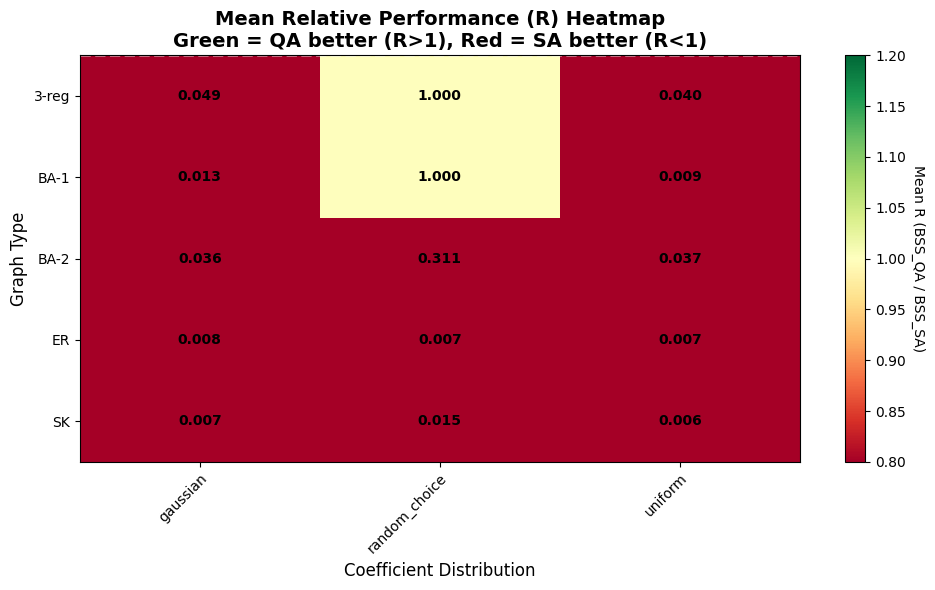

In [74]:
# Create heatmap of mean R values

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create a pivot table for the heatmap
heatmap_data = comparison_df.pivot_table(
    values="R",
    index="graph_type",
    columns="coeff_dist",
    aggfunc="mean"
)

# Create heatmap using matplotlib
im = ax.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0.8, vmax=1.2)

# Set ticks and labels
ax.set_xticks(np.arange(len(heatmap_data.columns)))
ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns)
ax.set_yticklabels(heatmap_data.index)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Mean R (BSS_QA / BSS_SA)", rotation=-90, va="bottom")

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        text = ax.text(j, i, f"{heatmap_data.values[i, j]:.3f}",
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title("Mean Relative Performance (R) Heatmap\nGreen = QA better (R>1), Red = SA better (R<1)", 
             fontsize=14, fontweight='bold')
ax.set_xlabel("Coefficient Distribution", fontsize=12)
ax.set_ylabel("Graph Type", fontsize=12)

# Add reference line at R=1
ax.axhline(y=-0.5, color='white', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig("r_heatmap.png", dpi=150, bbox_inches="tight")
print("Heatmap saved as 'r_heatmap.png'")
plt.show()


### Part 5: Steepest-Descent Postprocessing (SA vs. QA)

In this part, we apply **local optimization** (steepest descent) to improve the solutions from both SA and QA.

**Procedure:**
- For each instance:
  - Apply `SteepestDescentSolver` to all SA samples → compute new BSS (call it $S_{\text{SA+SD}}$)
  - Apply the same postprocessing to QA samples → compute $S_{\text{QA+SD}}$
  
**Analysis goals:**
1. **Improvement metrics:**
   - Compare $S_{\text{SA+SD}}$ vs. $S_{\text{SA}}$ (how much did SA improve?)
   - Compare $S_{\text{QA+SD}}$ vs. $S_{\text{QA}}$ (how much did QA improve?)
   
2. **Relative benefit:**
   - Which sampler gains more from postprocessing?
   - For which graph families does postprocessing help most?
   
3. **Why might SA and QA respond differently?**
   - Quality of initial solutions
   - Diversity of solution pools
   - Distance from local optima


In [76]:
# Imports for Part 5

from dwave.samplers import SteepestDescentSampler

# Initialize steepest descent sampler
sd_sampler = SteepestDescentSampler()

print("Steepest Descent sampler initialized.")


Steepest Descent sampler initialized.


In [77]:
# Apply steepest descent postprocessing to all SA and QA samples

# Storage for postprocessed results
sd_results = []

print(f"Applying steepest descent postprocessing to {len(problem_instances)} instances...")
print("=" * 80)

for idx, problem in enumerate(problem_instances):
    instance_counter = problem["instance_counter"]
    graph_type = problem["graph_type"]
    coeff_dist = problem["coeff_dist"]
    instance_id = problem["instance_id"]
    h = problem["h"]
    J = problem["J"]
    
    # Check if we have both SA and QA samplesets
    if "sa_sampleset" not in problem or "qa_sampleset" not in problem:
        print(f"[{idx+1}/{len(problem_instances)}] Skipping {graph_type} | {coeff_dist} | instance {instance_id}: missing samplesets")
        continue
    
    sa_sampleset = problem["sa_sampleset"]
    qa_sampleset = problem["qa_sampleset"]
    bqm = problem.get("bqm")
    
    # If BQM not stored, create it
    if bqm is None:
        bqm = dimod.BinaryQuadraticModel(h, J, offset=0.0, vartype=dimod.SPIN)
    
    print(f"\n[{idx+1}/{len(problem_instances)}] Processing: {graph_type} | {coeff_dist} | instance {instance_id}")
    
    try:
        # Apply steepest descent to SA samples
        sa_sd_sampleset = sd_sampler.sample(bqm, initial_states=sa_sampleset)
        bss_sa_sd, e_min_sa_sd, f_min_sa_sd = calculate_bss(sa_sd_sampleset)
        
        # Apply steepest descent to QA samples
        qa_sd_sampleset = sd_sampler.sample(bqm, initial_states=qa_sampleset)
        bss_qa_sd, e_min_qa_sd, f_min_qa_sd = calculate_bss(qa_sd_sampleset)
        
        # Get original BSS values
        bss_sa_orig, e_min_sa_orig, f_min_sa_orig = calculate_bss(sa_sampleset)
        bss_qa_orig, e_min_qa_orig, f_min_qa_orig = calculate_bss(qa_sampleset)
        
        # Calculate improvements
        sa_improvement = bss_sa_sd - bss_sa_orig  # More negative = better
        qa_improvement = bss_qa_sd - bss_qa_orig
        
        # Calculate relative improvements (percentage change)
        sa_rel_improvement = (bss_sa_sd / bss_sa_orig - 1) * 100 if bss_sa_orig != 0 else 0
        qa_rel_improvement = (bss_qa_sd / bss_qa_orig - 1) * 100 if bss_qa_orig != 0 else 0
        
        # Store results
        sd_results.append({
            "instance_counter": instance_counter,
            "graph_type": graph_type,
            "coeff_dist": coeff_dist,
            "instance_id": instance_id,
            # SA results
            "bss_sa_orig": bss_sa_orig,
            "bss_sa_sd": bss_sa_sd,
            "sa_improvement": sa_improvement,
            "sa_rel_improvement": sa_rel_improvement,
            # QA results
            "bss_qa_orig": bss_qa_orig,
            "bss_qa_sd": bss_qa_sd,
            "qa_improvement": qa_improvement,
            "qa_rel_improvement": qa_rel_improvement,
        })
        
        print(f"  SA: {bss_sa_orig:.2f} → {bss_sa_sd:.2f} (Δ={sa_improvement:.2f}, {sa_rel_improvement:+.1f}%)")
        print(f"  QA: {bss_qa_orig:.2f} → {bss_qa_sd:.2f} (Δ={qa_improvement:.2f}, {qa_rel_improvement:+.1f}%)")
        
    except Exception as e:
        print(f"  ERROR: {e}")
        continue

print("\n" + "=" * 80)
print(f"Completed steepest descent postprocessing for {len(sd_results)} instances.")

# Convert to DataFrame
sd_results_df = pd.DataFrame(sd_results)
sd_results_df.head(10)


Applying steepest descent postprocessing to 75 instances...

[1/75] Processing: SK | random_choice | instance 0
  SA: -26656.00 → -26656.00 (Δ=0.00, +0.0%)
  QA: -928.00 → -952.00 (Δ=-24.00, +2.6%)

[2/75] Processing: SK | random_choice | instance 1
  SA: -307092.00 → -307092.00 (Δ=0.00, +0.0%)
  QA: -962.00 → -8802.00 (Δ=-7840.00, +815.0%)

[3/75] Processing: SK | random_choice | instance 2
  SA: -53648.00 → -53648.00 (Δ=0.00, +0.0%)
  QA: -906.00 → -954.00 (Δ=-48.00, +5.3%)

[4/75] Processing: SK | random_choice | instance 3
  SA: -128372.00 → -128372.00 (Δ=0.00, +0.0%)
  QA: -922.00 → -958.00 (Δ=-36.00, +3.9%)

[5/75] Processing: SK | random_choice | instance 4
  SA: -70148.00 → -70148.00 (Δ=0.00, +0.0%)
  QA: -936.00 → -988.00 (Δ=-52.00, +5.6%)

[6/75] Processing: SK | uniform | instance 0
  SA: -77034.18 → -77034.18 (Δ=0.00, +0.0%)
  QA: -530.89 → -1662.61 (Δ=-1131.72, +213.2%)

[7/75] Processing: SK | uniform | instance 1
  SA: -64640.30 → -64640.30 (Δ=0.00, +0.0%)
  QA: -545.55 

,instance_counter,graph_type,coeff_dist,instance_id,bss_sa_orig,bss_sa_sd,sa_improvement,sa_rel_improvement,bss_qa_orig,bss_qa_sd,qa_improvement,qa_rel_improvement
0,1,SK,random_choice,0,-26656.000000,-26656.000000,0.0,0.0,-928.000000,-952.000000,-24.000000,2.586207
1,2,SK,random_choice,1,-307092.000000,-307092.000000,0.0,0.0,-962.000000,-8802.000000,-7840.000000,814.968815
2,3,SK,random_choice,2,-53648.000000,-53648.000000,0.0,0.0,-906.000000,-954.000000,-48.000000,5.298013
3,4,SK,random_choice,3,-128372.000000,-128372.000000,0.0,0.0,-922.000000,-958.000000,-36.000000,3.904555
4,5,SK,random_choice,4,-70148.000000,-70148.000000,0.0,0.0,-936.000000,-988.000000,-52.000000,5.555556
5,6,SK,uniform,0,-77034.184654,-77034.184654,0.0,0.0,-530.886412,-1662.608302,-1131.721889,213.175900
6,7,SK,uniform,1,-64640.304770,-64640.304770,0.0,0.0,-545.548932,-567.020217,-21.471285,3.935721
7,8,SK,uniform,2,-144214.911593,-144214.911593,0.0,0.0,-547.216952,-4489.180127,-3941.963175,720.365690
8,9,SK,uniform,3,-161872.962923,-161872.962923,0.0,0.0,-554.429487,-17281.810988,-16727.381501,3017.043988
9,10,SK,uniform,4,-76504.605568,-76504.605568,0.0,0.0,-543.097055,-4467.422223,-3924.325168,722.582663


In [78]:
# Summary statistics: How much did each sampler improve?

print("POSTPROCESSING IMPROVEMENT SUMMARY")
print("=" * 100)
print("\nOverall Statistics:")
print(f"  Total instances: {len(sd_results_df)}")
print(f"\n  SA Improvements:")
print(f"    Mean absolute improvement: {sd_results_df['sa_improvement'].mean():.2f}")
print(f"    Mean relative improvement: {sd_results_df['sa_rel_improvement'].mean():.2f}%")
print(f"    Instances improved: {(sd_results_df['sa_improvement'] < 0).sum()} ({(sd_results_df['sa_improvement'] < 0).sum() / len(sd_results_df) * 100:.1f}%)")
print(f"\n  QA Improvements:")
print(f"    Mean absolute improvement: {sd_results_df['qa_improvement'].mean():.2f}")
print(f"    Mean relative improvement: {sd_results_df['qa_rel_improvement'].mean():.2f}%")
print(f"    Instances improved: {(sd_results_df['qa_improvement'] < 0).sum()} ({(sd_results_df['qa_improvement'] < 0).sum() / len(sd_results_df) * 100:.1f}%)")

# Determine which sampler benefited more overall
sa_total_gain = sd_results_df['sa_rel_improvement'].mean()
qa_total_gain = sd_results_df['qa_rel_improvement'].mean()

print(f"\n" + "=" * 100)
if abs(sa_total_gain) > abs(qa_total_gain):
    print(f"RESULT: SA benefits MORE from postprocessing ({sa_total_gain:.2f}% vs {qa_total_gain:.2f}%)")
elif abs(qa_total_gain) > abs(sa_total_gain):
    print(f"RESULT: QA benefits MORE from postprocessing ({qa_total_gain:.2f}% vs {sa_total_gain:.2f}%)")
else:
    print(f"RESULT: Both samplers benefit equally from postprocessing ({sa_total_gain:.2f}%)")


POSTPROCESSING IMPROVEMENT SUMMARY

Overall Statistics:
  Total instances: 75

  SA Improvements:
    Mean absolute improvement: -72.73
    Mean relative improvement: 2.76%
    Instances improved: 5 (6.7%)

  QA Improvements:
    Mean absolute improvement: -3681.21
    Mean relative improvement: 2571.85%
    Instances improved: 62 (82.7%)

RESULT: QA benefits MORE from postprocessing (2571.85% vs 2.76%)


In [79]:
# Breakdown by graph type: Which families benefit most from postprocessing?

print("\nIMPROVEMENTS BY GRAPH TYPE")
print("=" * 100)

for graph_type in GRAPH_TYPES:
    gt_data = sd_results_df[sd_results_df["graph_type"] == graph_type]
    
    if len(gt_data) == 0:
        continue
    
    sa_mean_imp = gt_data["sa_rel_improvement"].mean()
    qa_mean_imp = gt_data["qa_rel_improvement"].mean()
    
    print(f"\n{graph_type}:")
    print(f"  SA: {sa_mean_imp:+.2f}% average improvement")
    print(f"  QA: {qa_mean_imp:+.2f}% average improvement")
    
    if abs(sa_mean_imp) > abs(qa_mean_imp):
        print(f"  → SA benefits MORE from postprocessing on {graph_type}")
    elif abs(qa_mean_imp) > abs(sa_mean_imp):
        print(f"  → QA benefits MORE from postprocessing on {graph_type}")
    else:
        print(f"  → Both benefit equally on {graph_type}")

print("\n" + "=" * 100)
print("\nIMPROVEMENTS BY COEFFICIENT DISTRIBUTION")
print("=" * 100)

for coeff_dist in COEFF_DISTRIBUTIONS:
    cd_data = sd_results_df[sd_results_df["coeff_dist"] == coeff_dist]
    
    if len(cd_data) == 0:
        continue
    
    sa_mean_imp = cd_data["sa_rel_improvement"].mean()
    qa_mean_imp = cd_data["qa_rel_improvement"].mean()
    
    print(f"\n{coeff_dist}:")
    print(f"  SA: {sa_mean_imp:+.2f}% average improvement")
    print(f"  QA: {qa_mean_imp:+.2f}% average improvement")
    
    if abs(sa_mean_imp) > abs(qa_mean_imp):
        print(f"  → SA benefits MORE from postprocessing on {coeff_dist}")
    elif abs(qa_mean_imp) > abs(sa_mean_imp):
        print(f"  → QA benefits MORE from postprocessing on {coeff_dist}")
    else:
        print(f"  → Both benefit equally on {coeff_dist}")



IMPROVEMENTS BY GRAPH TYPE

SK:
  SA: +0.00% average improvement
  QA: +466.11% average improvement
  → QA benefits MORE from postprocessing on SK

3-reg:
  SA: +0.00% average improvement
  QA: +428.00% average improvement
  → QA benefits MORE from postprocessing on 3-reg

ER:
  SA: +0.00% average improvement
  QA: +85.24% average improvement
  → QA benefits MORE from postprocessing on ER

BA-1:
  SA: +8.57% average improvement
  QA: +11171.32% average improvement
  → QA benefits MORE from postprocessing on BA-1

BA-2:
  SA: +5.24% average improvement
  QA: +708.60% average improvement
  → QA benefits MORE from postprocessing on BA-2


IMPROVEMENTS BY COEFFICIENT DISTRIBUTION

random_choice:
  SA: +1.43% average improvement
  QA: +37.53% average improvement
  → QA benefits MORE from postprocessing on random_choice

uniform:
  SA: +0.00% average improvement
  QA: +3557.66% average improvement
  → QA benefits MORE from postprocessing on uniform

gaussian:
  SA: +6.86% average improvemen

Heatmaps saved as 'postprocessing_heatmaps.png'


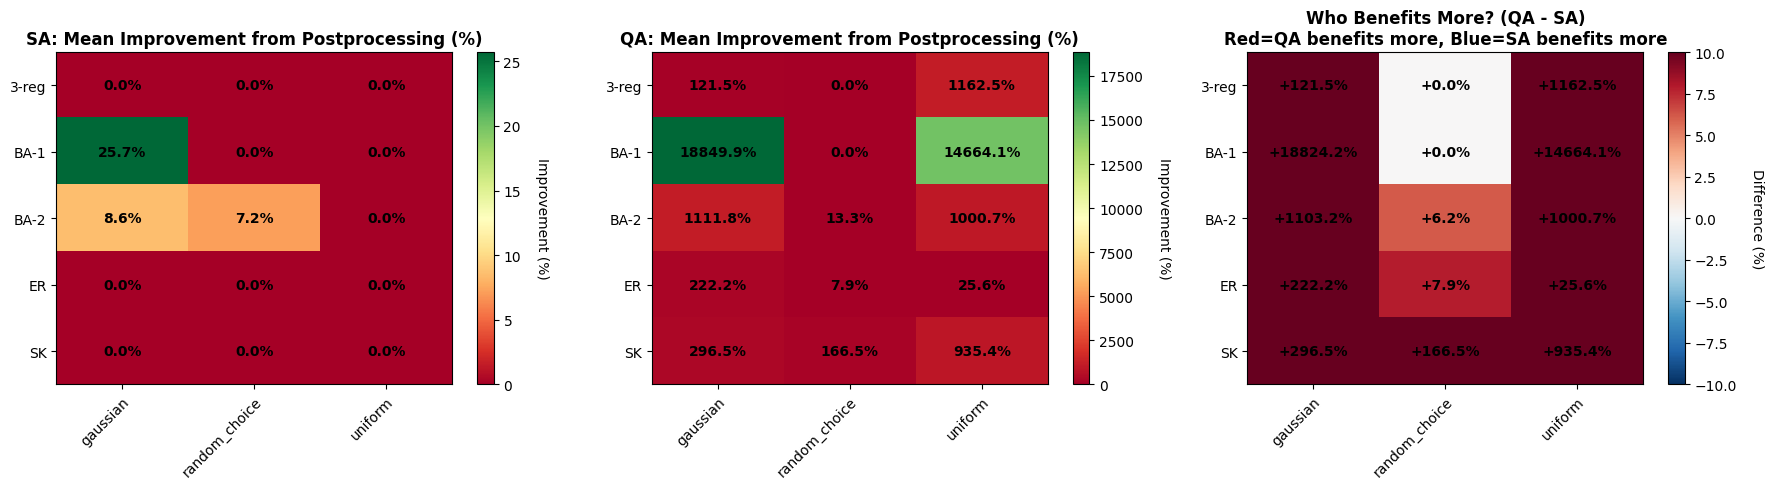

In [81]:
# Create heatmaps comparing SA vs QA improvements

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap 1: SA improvements
sa_improvement_pivot = sd_results_df.pivot_table(
    values="sa_rel_improvement",
    index="graph_type",
    columns="coeff_dist",
    aggfunc="mean"
)

im1 = axes[0].imshow(sa_improvement_pivot.values, cmap='RdYlGn', aspect='auto')
axes[0].set_xticks(np.arange(len(sa_improvement_pivot.columns)))
axes[0].set_yticks(np.arange(len(sa_improvement_pivot.index)))
axes[0].set_xticklabels(sa_improvement_pivot.columns)
axes[0].set_yticklabels(sa_improvement_pivot.index)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(sa_improvement_pivot.index)):
    for j in range(len(sa_improvement_pivot.columns)):
        text = axes[0].text(j, i, f"{sa_improvement_pivot.values[i, j]:.1f}%",
                           ha="center", va="center", color="black", fontweight='bold')

axes[0].set_title("SA: Mean Improvement from Postprocessing (%)", fontsize=12, fontweight='bold')
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label("Improvement (%)", rotation=270, labelpad=20)

# Heatmap 2: QA improvements
qa_improvement_pivot = sd_results_df.pivot_table(
    values="qa_rel_improvement",
    index="graph_type",
    columns="coeff_dist",
    aggfunc="mean"
)

im2 = axes[1].imshow(qa_improvement_pivot.values, cmap='RdYlGn', aspect='auto')
axes[1].set_xticks(np.arange(len(qa_improvement_pivot.columns)))
axes[1].set_yticks(np.arange(len(qa_improvement_pivot.index)))
axes[1].set_xticklabels(qa_improvement_pivot.columns)
axes[1].set_yticklabels(qa_improvement_pivot.index)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(qa_improvement_pivot.index)):
    for j in range(len(qa_improvement_pivot.columns)):
        text = axes[1].text(j, i, f"{qa_improvement_pivot.values[i, j]:.1f}%",
                           ha="center", va="center", color="black", fontweight='bold')

axes[1].set_title("QA: Mean Improvement from Postprocessing (%)", fontsize=12, fontweight='bold')
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label("Improvement (%)", rotation=270, labelpad=20)

# Heatmap 3: Difference (QA - SA) - who benefits more?
diff_pivot = qa_improvement_pivot - sa_improvement_pivot

im3 = axes[2].imshow(diff_pivot.values, cmap='RdBu_r', aspect='auto', vmin=-10, vmax=10)
axes[2].set_xticks(np.arange(len(diff_pivot.columns)))
axes[2].set_yticks(np.arange(len(diff_pivot.index)))
axes[2].set_xticklabels(diff_pivot.columns)
axes[2].set_yticklabels(diff_pivot.index)
plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(diff_pivot.index)):
    for j in range(len(diff_pivot.columns)):
        val = diff_pivot.values[i, j]
        text = axes[2].text(j, i, f"{val:+.1f}%",
                           ha="center", va="center", color="black", fontweight='bold')

axes[2].set_title("Who Benefits More? (QA - SA)\nRed=QA benefits more, Blue=SA benefits more", 
                  fontsize=12, fontweight='bold')
cbar3 = fig.colorbar(im3, ax=axes[2])
cbar3.set_label("Difference (%)", rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig("postprocessing_heatmaps.png", dpi=150, bbox_inches="tight")
print("Heatmaps saved as 'postprocessing_heatmaps.png'")
plt.show()
